In [38]:
import os
import numpy as np
import tensorflow as tf
from os.path import join
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.datasets import load_files
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd
from sklearn import metrics

In [2]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [3]:
#SPLIT FOLDER SUDAH DILAKUKAN 1X DAN TINGGAL DIGUNAKAN
train = './Dataset_CV/train'
val = './Dataset_CV/val'
test = './Dataset_CV/test'

In [4]:
img_folders_train = [join(train, dir) for dir in os.listdir(train)]
img_folders_val  = [join(val, dir) for dir in os.listdir(val)]
img_folders_test = [join(test, dir) for dir in os.listdir(test)]
list(img_folders_train)
list(img_folders_val)
list(img_folders_test)

['./Dataset_CV/test\\bluebell',
 './Dataset_CV/test\\buttercup',
 './Dataset_CV/test\\cowslip',
 './Dataset_CV/test\\crocus',
 './Dataset_CV/test\\daffodil',
 './Dataset_CV/test\\daisy',
 './Dataset_CV/test\\dandelion',
 './Dataset_CV/test\\fritillary',
 './Dataset_CV/test\\iris',
 './Dataset_CV/test\\pansy',
 './Dataset_CV/test\\rose',
 './Dataset_CV/test\\snowdrop',
 './Dataset_CV/test\\sunflower',
 './Dataset_CV/test\\tiger lily',
 './Dataset_CV/test\\tulip',
 './Dataset_CV/test\\windflower']

In [5]:
images_train = load_files(train)
images_val = load_files(val)
images_test = load_files(test)
X_train = np.array(images_train['filenames'])
y_train = np.array(images_train['target'])
X_val = np.array(images_val['filenames'])
y_val = np.array(images_val['target'])
X_test = np.array(images_test['filenames'])
y_test = np.array(images_test['target'])

labels_train = np.array(images_train['target_names'])
labels_val = np.array(images_val['target_names'])
labels_test = np.array(images_test['target_names'])

In [6]:
print(f'Target labels train (digits) - {y_train}')
print(f'Target labels train (names) - {labels_train}')
print(f'Number of uploaded train images : {X_train.shape[0]}')

print(f'Target labels val (digits) - {y_val}')
print(f'Target labels val (names) - {labels_val}')
print(f'Number of uploaded val images : {X_val.shape[0]}')

print(f'Target labels test (digits) - {y_test}')
print(f'Target labels test (names) - {labels_test}')
print(f'Number of uploaded test images : {X_test.shape[0]}')

Target labels train (digits) - [11 13 10 ... 11  8 10]
Target labels train (names) - ['bluebell' 'buttercup' 'cowslip' 'crocus' 'daffodil' 'daisy' 'dandelion'
 'fritillary' 'iris' 'pansy' 'rose' 'snowdrop' 'sunflower' 'tiger lily'
 'tulip' 'windflower']
Number of uploaded train images : 1088
Target labels val (digits) - [14  4  5 14 10  1  6 12  2 13  6 11  3  9  5 11  6  8 15 11  0  3 11  1
  7 11  2  0  6  7 10  6  3 13  8  7  7 13 15  1  5 13  7 10  1  7  5 12
 15  0 12 13  0 11 12 12  9 14  9  8 11 12  3  2 15  1 10 11  5 11  0 11
 14  5  0  2  4  0  6 15 13  0  4  3  6  9  4  2  9  3 11  7 12 14  4 14
  1 11  2  3  6 13 11 10  8 15  9  8 10  2 15  9  9  3  4 10 14  5 15  4
 11  8  7  1 14 11  8 10  4  2  1 11  8 13  5]
Target labels val (names) - ['bluebell' 'buttercup' 'cowslip' 'crocus' 'daffodil' 'daisy' 'dandelion'
 'fritillary' 'iris' 'pansy' 'rose' 'snowdrop' 'sunflower' 'tiger lily'
 'tulip' 'windflower']
Number of uploaded val images : 135
Target labels test (digits) - [ 3

In [7]:
flowers_train = pd.DataFrame({'species': y_train})
flowers_train.count()

species    1088
dtype: int64

In [8]:
flowers_val = pd.DataFrame({'species': y_val})
flowers_val.count()

species    135
dtype: int64

In [9]:
flowers_test = pd.DataFrame({'species': y_test})
flowers_test.count()

species    137
dtype: int64

In [10]:
def imageLoadConverter(img_paths):
    images = [load_img(img_path, target_size=IMG_SIZE) for img_path in img_paths]
    images_array = np.array([img_to_array(img) for img in images])
    
    return(images_array)

X_train = np.array(imageLoadConverter(X_train))
X_val = np.array(imageLoadConverter(X_val))
X_test = np.array(imageLoadConverter(X_test))

In [11]:
num_classes= len(np.unique(y_train))

In [12]:
print(num_classes)

16


In [13]:
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)

In [14]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

In [15]:
train_generator = datagen.flow(
    X_train, y_train, 
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [16]:
val_generator = datagen.flow(
    X_val, y_val,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [17]:
test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)

test_generator = test_datagen.flow(
    X_test, y_test,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [18]:
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [19]:
for layer in vgg16_base.layers:
    layer.trainable = False

num_classes = len(np.unique(y_train)) 

x = Flatten()(vgg16_base.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(16, activation='softmax')(x)

In [20]:
model = Model(inputs=vgg16_base.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [21]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │         4,112 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,141,584 (80.65 MB)

 Trainable params: 6,426,896 (24.52 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [22]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [23]:
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

c:\Users\Angel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 110s 3s/step - accuracy: 0.1298 - loss: 2.9142 - val_accuracy: 0.4741 - val_loss: 2.1531
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 109s 3s/step - accuracy: 0.3746 - loss: 2.0903 - val_accuracy: 0.5407 - val_loss: 1.6843
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 109s 3s/step - accuracy: 0.4616 - loss: 1.7111 - val_accuracy: 0.6148 - val_loss: 1.4216
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 109s 3s/step - accuracy: 0.5737 - loss: 1.4496 - val_accuracy: 0.7037 - val_loss: 1.2121
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 109s 3s/step - accuracy: 0.6211 - loss: 1.2860 - val_accuracy: 0.6889 - val_loss: 1.2222
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 109s 3s/step - accuracy: 0.6145 - loss: 1.2716 - val_accuracy: 0.6889 - val_loss: 1.0593
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 109s 3s/step - accuracy: 0.6693 - loss: 1.1578 - val_accuracy: 0.7037 - val_loss: 0.9811
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 109s 3s/step - accuracy: 0.6871 - loss: 1.0675 - val_accuracy: 0.7333 - v

In [24]:
print(f"Train Accuracy: {history.history['accuracy'][-1] * 100:.2f}%")

Train Accuracy: 82.54%


In [48]:
print(f"Validation Accuracy: {history.history['val_accuracy'][-1] * 100:.2f}%")

Validation Accuracy: 73.33%


In [26]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.7976 - loss: 0.6270
Test Accuracy: 80.29%


In [27]:
# model.save('vgg16.h5')    

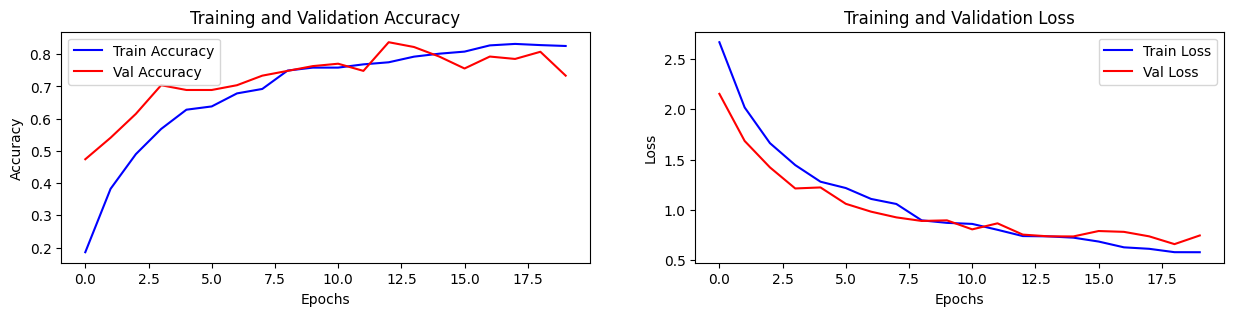

In [47]:
plt.figure(figsize=(15, 3))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='b')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', color='r')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='b')
plt.plot(history.history['val_loss'], label='Val Loss', color='r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.savefig('vgg16-plot.png')
plt.show()

In [29]:
y_pred_probabilities = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred_probabilities, axis=1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step


In [30]:
loss, acc = model.evaluate(val_generator, verbose=0)
print(f'Validation loss: {loss:.2f}%')
print(f'Validation accuracy: {acc*100:.2f}%')

Validation loss: 0.67%
Validation accuracy: 82.22%


In [31]:
y_pred_val = model.predict(val_generator)

5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step


In [32]:
y_true_val = y_val.argmax(axis=1)
y_pred_val = y_pred_val.argmax(axis=1)

In [33]:
print(f"Length of y_true_val: {len(y_true_val)}")
print(f"Length of y_pred_val: {len(y_pred_val)}")

Length of y_true_val: 135
Length of y_pred_val: 135


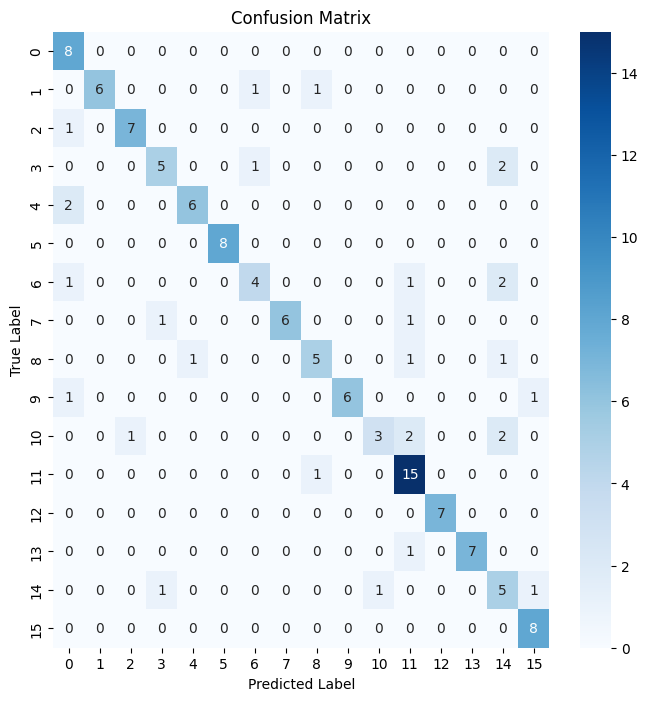

In [46]:
confusion_mtx = confusion_matrix(y_true_val, y_pred_val) 

f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap=plt.cm.Blues)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.savefig("vgg16-confusionmatrix.png")
plt.show()

In [36]:
y_true = y_test.argmax(axis=1)

In [40]:
print("Classification Report:")
print(metrics.classification_report(y_true, y_pred_classes))

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.75      0.80         8
           1       0.83      0.62      0.71         8
           2       0.54      0.88      0.67         8
           3       0.75      0.75      0.75         8
           4       0.50      0.25      0.33         8
           5       0.88      0.78      0.82         9
           6       0.88      0.88      0.88         8
           7       1.00      0.75      0.86         8
           8       1.00      0.88      0.93         8
           9       0.86      0.75      0.80         8
          10       1.00      0.75      0.86         8
          11       0.73      1.00      0.84        16
          12       1.00      0.88      0.93         8
          13       0.80      1.00      0.89         8
          14       0.64      0.88      0.74         8
          15       1.00      0.88      0.93         8

    accuracy                           0.80       137
   

In [43]:
# category = ["Bluebell", "Buttercup", "Cowslip", "Crocus", "Daffodil", "Daisy", "Dandelion", "Fritillary", "Iris", "Pansy", "Rose" ,"Snowdrop", "Sunflower", "Tiger Lily", "Tulip", "Windflower"]
# def preprocess_input_image(img_path):
#     img = load_img(img_path, target_size=(150, 150))
#     img_array = img_to_array(img)
#     img_array = np.expand_dims(img_array, axis=0) 
#     img_array /= 255.0
#     return img_array
# def predict_flower(img_path, model):
#     img_array = preprocess_input_image(img_path)
#     predictions = model.predict(img_array)
#     predicted_class_idx = np.argmax(predictions, axis=1)[0]
#     flower_name = category[predicted_class_idx]

#     plt.imshow(load_img(img_path))
#     plt.axis('off')
#     plt.title(f"Predicted Flower: {flower_name}")
#     plt.show()

#     return flower_name

# img_path = './tulip.jpg'
# predicted_flower = predict_flower(img_path, model)
# print(f"The predicted flower is: {predicted_flower}")